# 1. Initializations and Dataset Download

In [3]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/ML/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 96% 274M/285M [00:00<00:00, 338MB/s]
100% 285M/285M [00:00<00:00, 395MB/s]


In [8]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d facial-expression-recognition-dataset

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: facial-expression-recognition-dataset/example_submission.csv  
  inflating: facial-expression-recognition-dataset/fer2013.tar.gz  
  inflating: facial-expression-recognition-dataset/icml_face_data.csv  
  inflating: facial-expression-recognition-dataset/test.csv  
  inflating: facial-expression-recognition-dataset/train.csv  


In [9]:
!tar -xzvf facial-expression-recognition-dataset/fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


Now I should have directory `facial-expression-recognition-dataset` containing dataset files from kaggle

# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.

In [10]:
import torch # Main PyTorch Library
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import wandb
import seaborn as sns

from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
from sklearn.model_selection import train_test_split # Train/Test split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image # Used to read the images from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


# 3. Data Exploration

### 3.1 Data Loading

In [11]:
df = pd.read_csv('fer2013/fer2013.csv')

train_df = df[df['Usage'] == 'Training'].drop('Usage', axis=1)
val_df = df[df['Usage'] == "PublicTest"].drop('Usage', axis=1)
test_df = df[df['Usage'] == "PrivateTest"].drop('Usage', axis=1)

print(f"trainset shape: {train_df.shape}")
print(f"valset shape: {val_df.shape}")
print(f"testset shape: {test_df.shape}")
print(f"\nEmotion distribution in trainset:")
print(train_df['emotion'].value_counts().sort_values(ascending=False))

emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

trainset shape: (28709, 2)
valset shape: (3589, 2)
testset shape: (3589, 2)

Emotion distribution in trainset:
emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64


### 3.2 Data Inspection

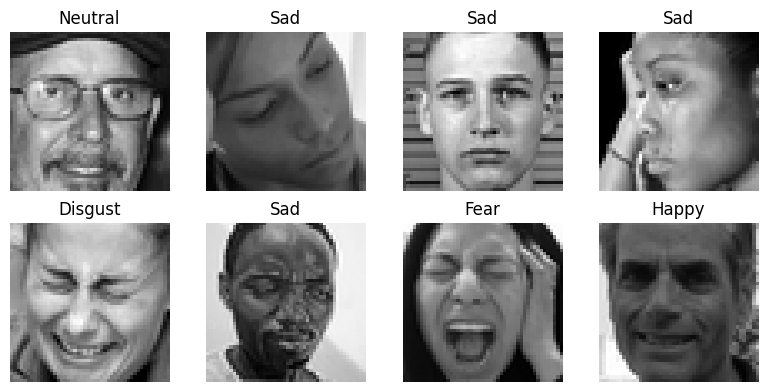

In [12]:
def plot_sample_images(df, num_samples=8):
    _, axes = plt.subplots(2, 4, figsize=(8, 4))
    axes = axes.ravel()

    for i in range(num_samples):
        # random sample
        idx = np.random.randint(0, len(df))
        emotion = df.iloc[idx]['emotion']
        pixels = df.iloc[idx]['pixels']

        # convert bytearray to grayscale image
        pixel_values = np.array(pixels.split(), dtype=np.uint8)
        image = pixel_values.reshape(48, 48)

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'{emotion_labels[emotion]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_df)

### 3.3 Custom Dataset Class

In [13]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        pixels = self.dataframe.iloc[idx]['pixels']
        pixel_values = np.array(pixels.split(), dtype=np.uint8)
        image = pixel_values.reshape(48, 48, 1) # add channel
        image = Image.fromarray(image.squeeze(), mode='L') # convert to PIL image

        if self.transform:
            image = self.transform(image)

        emotion = self.dataframe.iloc[idx]['emotion']
        return image, emotion

### 3.4 Data Transforms and Data Loaders

In [14]:
train_transform_chain = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # randomly flip horizontally, try to maintain symmetry between turned faces
    transforms.RandomRotation(degrees=10), # randomly rotate with -10/+10 degrees, try to maintain symmetry between tilted faces
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform_chain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# create datasets
train_dataset = FERDataset(train_df.reset_index(drop=True), transform=train_transform_chain)
val_dataset = FERDataset(val_df, transform=val_transform_chain)
test_dataset = FERDataset(test_df, transform=val_transform_chain)

# 4. Training

## 4.1 Define training helpers

In [15]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()           # set model to training mode (for BN and Dropout, to only include in training phase)
    running_loss = 0.0      # total loss across all batches
    correct = 0             # correct predictions
    total = 0               # total number of images processed

    # iterate through all batches in the training data loader (tqdm for progress bar to estimate time remaining)
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device) # use GPU

        optimizer.zero_grad()               # clear gradients from previous batch
        output = model(inputs)              # forward
        loss = criterion(output, labels)    # loss
        loss.backward()                     # backward
        optimizer.step()                    # update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)        # predicted class
        total += labels.size(0)                         # update total number of images processed
        correct += (predicted == labels).sum().item()   # update count of correct predictions

    epoch_loss = running_loss / len(train_loader)   # average loss per batch
    epoch_acc = correct / total * 100.              # accuracy as percentage

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()            # set model to evaluation mode (disables dropout, BN uses running info)
    running_loss = 0.0      # total validation loss
    correct = 0             # correct predictions
    total = 0               # total number of validation images
    preds = []              # predictions
    true_labels = []        # true labels

    # without gradient computation
    with torch.no_grad():

        # iterate through all batches in the validation data loader
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)   # use GPU
            output = model(inputs)                                  # forward
            loss = criterion(output, labels)                        # loss

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)        # predicted class
            total += labels.size(0)                         # update total number of images processed
            correct += (predicted == labels).sum().item()   # update count of correct predictions

            # numpy works with CPU
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)     # average loss per batch
    epoch_acc = correct / total * 100.              # accuracy as percentage

    return epoch_loss, epoch_acc, preds, true_labels

def train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion, device, model_name):
    # initialize wandb
    wandb.init(
        project="Facial Expression Recognition",
        name=model_name,
        config={
            "model": model_name,
            "epochs": num_epochs,
            "optimizer": optimizer.__class__.__name__,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "batch_size": train_loader.batch_size,
        }
    )

    # watch gradients
    wandb.watch(model, log="all")

    train_losses = []   # training loss per epoch
    train_accs = []     # training accuracy per epoch
    val_losses = []     # validation loss per epoch
    val_accs = []       # validation accuracy per epoch

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # validate
        val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device)

        # store metrics for plotting
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        })

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # save best model
        best_val_acc = max(best_val_acc, val_acc)

    # plotting
    plt.figure(figsize=(15, 5))

    # loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')      # training loss over epochs
    plt.plot(val_losses, label='Val Loss')          # validation loss over epochs
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')     # training accuracy over epochs
    plt.plot(val_accs, label='Val Acc')         # validation accuracy over epochs
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # log final metrics to wandb
    wandb.log({
        "best_val_accuracy": best_val_acc,
        "final_train_accuracy": train_accs[-1],
        "final_val_accuracy": val_accs[-1],
    })

    # log model
    model.eval()
    dummy_input = torch.randn(1, 1, 48, 48).to(device) # dummy input for exporting
    torch.onnx.export(model, dummy_input, f"{model_name}.onnx")
    wandb.save(f"{model_name}.onnx")

    wandb.finish()

    return train_losses, train_accs, val_losses, val_accs, best_val_acc

In [16]:
# hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 0.005

# data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# results
results = {}

## 4.2 Architectures

### 4.2.1 Basic CNN (No BatchNorm, No Dropout)

In [17]:
# 1. conv layer 1
#    ReLU
#    max pooling

# 2. conv layer 2
#    ReLU
#    max pooling

# 3. conv layer 3
#    ReLU
#    max pooling

# 4. flatten
# 5. linear layer
# 6. softmax

class BasicCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.conv_layers = nn.Sequential(
            # conv 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 32 x 48 x 48
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 x 24 x 24

            # conv 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64 x 24 x 24
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 12 x 12

            # conv 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128 x 12 x 12
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 x 6 x 6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(), # breaking linearity
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

In [18]:
print("Architecture 1: Basic CNN (No BatchNorm, No Dropout)")
model1 = BasicCNN().to(device)
optimizer1 = Adam(model1.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses1, train_accs1, val_losses1, val_accs1, best_acc1 = train_model(
    model1, train_loader, val_loader, NUM_EPOCHS, optimizer1, criterion, device, "Basic_CNN"
)
results["Basic_CNN"] = best_acc1

Architecture 1: Basic CNN (No BatchNorm, No Dropout)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: b3tameche (b3tameche-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/10
----------


Training:  58%|█████▊    | 260/449 [01:55<01:23,  2.25it/s]


KeyboardInterrupt: 

In [76]:
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


Epoch 1/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.80it/s]


Train Loss: 2.0640, Train Acc: 25.12%
Val Loss: 1.7406, Val Acc: 30.45%

Epoch 2/10
----------


Validation: 100%|██████████| 57/57 [00:03<00:00, 14.88it/s]


Train Loss: 1.6894, Train Acc: 32.59%
Val Loss: 1.6271, Val Acc: 35.00%

Epoch 3/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.35it/s]


Train Loss: 1.6336, Train Acc: 35.29%
Val Loss: 1.5918, Val Acc: 37.39%

Epoch 4/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.28it/s]


Train Loss: 1.6081, Train Acc: 36.56%
Val Loss: 1.5822, Val Acc: 37.75%

Epoch 5/10
----------


Validation: 100%|██████████| 57/57 [00:04<00:00, 13.65it/s]


Train Loss: 1.5855, Train Acc: 37.89%
Val Loss: 1.5528, Val Acc: 40.32%

Epoch 6/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 20.80it/s]


Train Loss: 1.5653, Train Acc: 38.59%
Val Loss: 1.5406, Val Acc: 39.90%

Epoch 7/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.39it/s]


Train Loss: 1.5355, Train Acc: 39.99%
Val Loss: 1.5388, Val Acc: 39.79%

Epoch 8/10
----------


Validation: 100%|██████████| 57/57 [00:03<00:00, 14.53it/s]


Train Loss: 1.5164, Train Acc: 40.99%
Val Loss: 1.4965, Val Acc: 41.10%

Epoch 9/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.87it/s]


Train Loss: 1.4945, Train Acc: 41.67%
Val Loss: 1.4823, Val Acc: 43.05%

Epoch 10/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.58it/s]


Train Loss: 1.4876, Train Acc: 42.14%
Val Loss: 1.4814, Val Acc: 42.27%


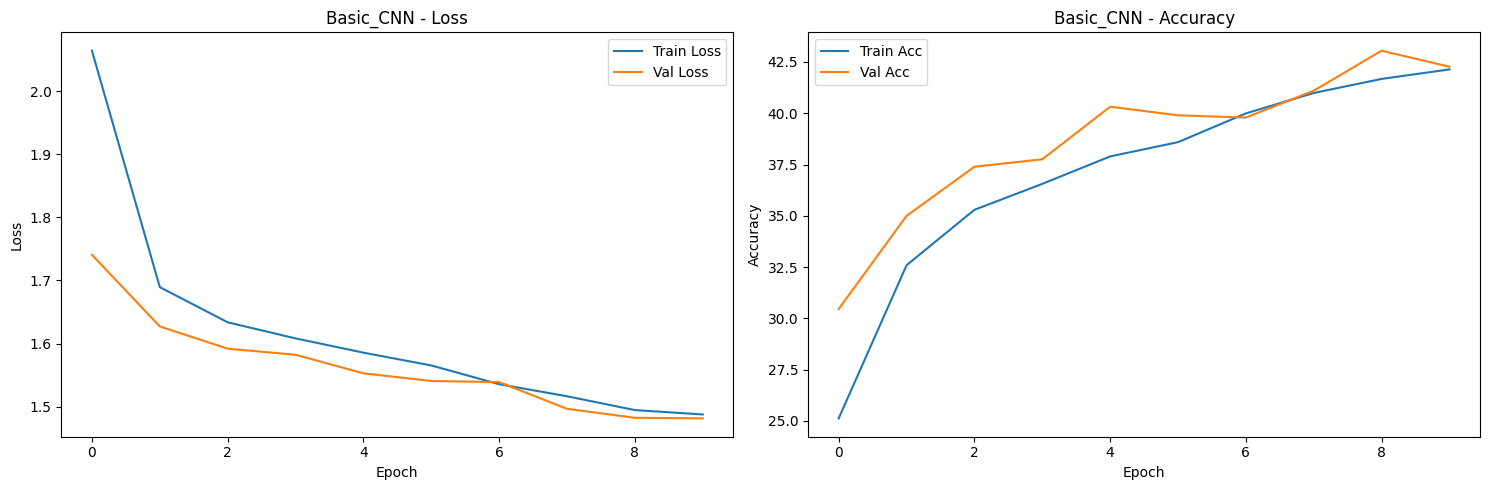

best_val_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▃▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▅▆▆▆▇██
val_loss,█▅▄▄▃▃▃▁▁▁
best_val_accuracy,43.0482
epoch,10
final_train_accuracy,42.13661


In [77]:
model2 = BasicCNN().to(device)
model2.apply(init_weights_kaiming)
optimizer2 = Adam(model2.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses2, train_accs2, val_losses2, val_accs2, best_acc2 = train_model(
    model2, train_loader, val_loader, NUM_EPOCHS, optimizer2, criterion, device, "Basic_CNN"
)

### 4.2.2 CNN with BatchNorm

In [78]:
# 1. conv layer 1
#    BN
#    ReLU
#    max pooling

# 2. conv layer 2
#    BN
#    ReLU
#    max pooling

# 3. conv layer 3
#    BN
#    ReLU
#    max pooling

# 4. flatten
# 5. linear layer
# 6. BN
# 8. linear layer
# 9. softmax

class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.features = nn.Sequential(
            # conv 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 32 x 48 x 48
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 x 24 x 24

            # conv 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64 x 24 x 24
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 12 x 12

            # conv 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128 x 12 x 12
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 x 6 x 6
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Architecture 2: CNN with Batch Normalization



Epoch 1/10
----------


Validation: 100%|██████████| 57/57 [00:04<00:00, 13.57it/s]


Train Loss: 1.5654, Train Acc: 39.67%
Val Loss: 1.3342, Val Acc: 48.73%

Epoch 2/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.16it/s]


Train Loss: 1.2704, Train Acc: 51.41%
Val Loss: 1.2382, Val Acc: 53.75%

Epoch 3/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.20it/s]


Train Loss: 1.1790, Train Acc: 55.37%
Val Loss: 1.1791, Val Acc: 56.20%

Epoch 4/10
----------


Validation: 100%|██████████| 57/57 [00:04<00:00, 13.14it/s]


Train Loss: 1.1140, Train Acc: 57.80%
Val Loss: 1.1380, Val Acc: 57.15%

Epoch 5/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 22.18it/s]


Train Loss: 1.0602, Train Acc: 59.89%
Val Loss: 1.1689, Val Acc: 57.37%

Epoch 6/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.00it/s]


Train Loss: 1.0108, Train Acc: 62.00%
Val Loss: 1.1546, Val Acc: 58.12%

Epoch 7/10
----------


Validation: 100%|██████████| 57/57 [00:04<00:00, 13.75it/s]


Train Loss: 0.9652, Train Acc: 63.66%
Val Loss: 1.1638, Val Acc: 58.01%

Epoch 8/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.01it/s]


Train Loss: 0.9227, Train Acc: 65.33%
Val Loss: 1.1428, Val Acc: 59.91%

Epoch 9/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 20.89it/s]


Train Loss: 0.8758, Train Acc: 67.50%
Val Loss: 1.1396, Val Acc: 59.63%

Epoch 10/10
----------


Validation: 100%|██████████| 57/57 [00:04<00:00, 13.88it/s]


Train Loss: 0.8229, Train Acc: 69.56%
Val Loss: 1.1778, Val Acc: 59.74%


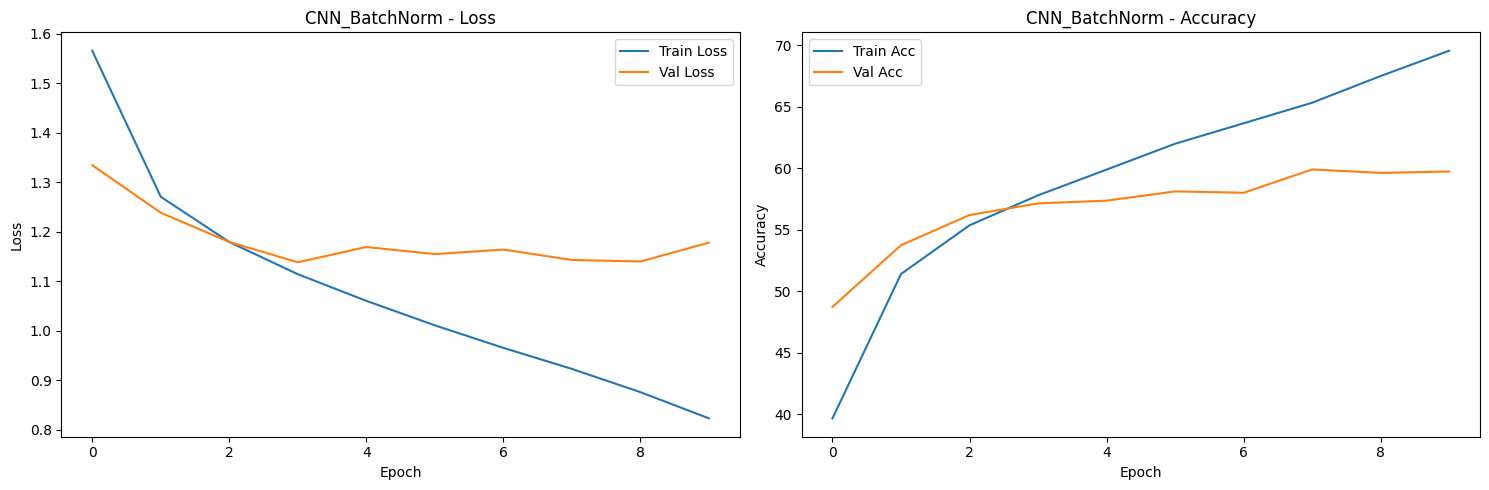

best_val_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▄▆▆▆▇▇███
val_loss,█▅▂▁▂▂▂▁▁▂
best_val_accuracy,59.90527
epoch,10
final_train_accuracy,69.56007


In [80]:
print("Architecture 2: CNN with Batch Normalization")
model2 = CNNWithBatchNorm().to(device)
optimizer2 = Adam(model2.parameters(), lr=0.01)

train_losses2, train_accs2, val_losses2, val_accs2, best_acc2 = train_model(
    model2, train_loader, val_loader, NUM_EPOCHS, optimizer2, criterion, device, "CNN_BatchNorm"
)
results["CNN_BatchNorm"] = best_acc2

### 4.2.3 CNN with Batchnorm and Dropout

In [81]:
# 1. conv layer 1
#    BN
#    ReLU
#    max pooling
#    dropout

# 2. conv layer 2
#    BN
#    ReLU
#    max pooling
#    dropout

# 3. conv layer 3
#    BN
#    ReLU
#    max pooling
#    dropout

# 4. flatten
# 5. linear layer
# 6. BN
# 7. dropout
# 8. linear layer

class CNNWithBatchNormDropout(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(CNNWithBatchNormDropout, self).__init__()

        self.features = nn.Sequential(
            # conv 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # conv 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            # conv 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Architecture 4: CNN with BatchNorm and Dropout



Epoch 1/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.86it/s]


Train Loss: 1.7610, Train Acc: 30.65%
Val Loss: 1.4944, Val Acc: 40.93%

Epoch 2/10
----------


Validation: 100%|██████████| 57/57 [00:04<00:00, 13.46it/s]


Train Loss: 1.5243, Train Acc: 40.65%
Val Loss: 1.3461, Val Acc: 47.67%

Epoch 3/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 22.05it/s]


Train Loss: 1.4301, Train Acc: 44.47%
Val Loss: 1.2846, Val Acc: 50.01%

Epoch 4/10
----------


Validation: 100%|██████████| 57/57 [00:03<00:00, 16.75it/s]


Train Loss: 1.3724, Train Acc: 47.28%
Val Loss: 1.2504, Val Acc: 51.41%

Epoch 5/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 19.92it/s]


Train Loss: 1.3262, Train Acc: 49.32%
Val Loss: 1.2119, Val Acc: 52.97%

Epoch 6/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 20.85it/s]


Train Loss: 1.3021, Train Acc: 50.07%
Val Loss: 1.1751, Val Acc: 54.69%

Epoch 7/10
----------


Validation: 100%|██████████| 57/57 [00:03<00:00, 16.78it/s]


Train Loss: 1.2735, Train Acc: 51.23%
Val Loss: 1.1622, Val Acc: 55.92%

Epoch 8/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 19.94it/s]


Train Loss: 1.2524, Train Acc: 51.69%
Val Loss: 1.1564, Val Acc: 55.87%

Epoch 9/10
----------


Validation: 100%|██████████| 57/57 [00:02<00:00, 21.92it/s]


Train Loss: 1.2371, Train Acc: 52.77%
Val Loss: 1.1277, Val Acc: 57.17%

Epoch 10/10
----------


Validation: 100%|██████████| 57/57 [00:03<00:00, 16.98it/s]


Train Loss: 1.2165, Train Acc: 53.51%
Val Loss: 1.1366, Val Acc: 55.95%


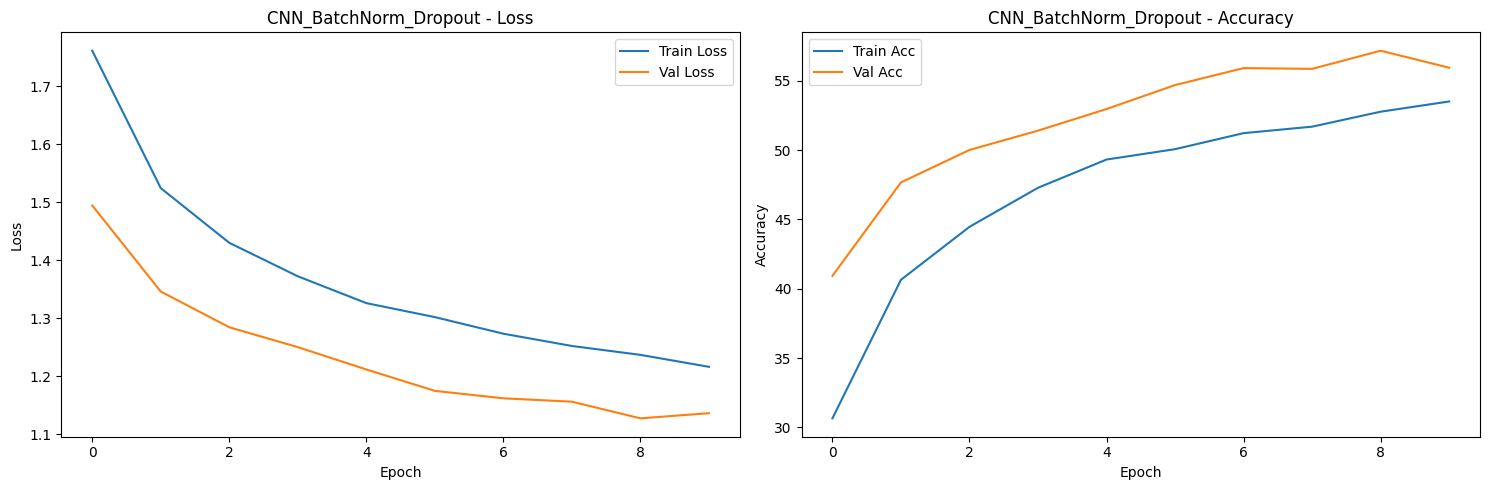

best_val_accuracy,▁
epoch,▁▂▃▃▄▅▆▆▇█
final_train_accuracy,▁
final_val_accuracy,▁
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇█▇
val_loss,█▅▄▃▃▂▂▂▁▁
best_val_accuracy,57.1747
epoch,10
final_train_accuracy,53.51284


In [82]:
print("Architecture 4: CNN with BatchNorm and Dropout")
model3 = CNNWithBatchNormDropout().to(device)
optimizer3 = Adam(model3.parameters(), lr=LR)

train_losses4, train_accs4, val_losses4, val_accs4, best_acc4 = train_model(
    model3, train_loader, val_loader, NUM_EPOCHS, optimizer3, criterion, device, "CNN_BatchNorm_Dropout"
)
results["CNN_BatchNorm_Dropout"] = best_acc4